## Opis projektu ##

Zbiór danych stanowi 30000 tweetów w języku angielskim oraz przypisane im etykiety emocji. Możliwe etykiety to: worry, neutral, sadness, happiness, love, suprise, hate, fun, relief, empty, entusiasm, boredom oraz anger. 

Po załadowaniu danych z tweetów usuwane są adresy url oraz znaki @. Następnie wpisy są normalizowane, co obejmuje: usunięcię z tweetów znaków spoza systemu ASCII, usunięcie interpunkcji, zastąpienie liczb ich słowną reprezentacją, usunięcie stop words oraz usunięcie słów, które nie znajdują się w słowniku języka angielskiego. 
Tweety, które po takiej obróbce będą puste, zostają usunięte. W tym przypadku było to 529 elementów. 

Następnie na wykresie słupkowym pokazano rozkład etykiet w oczyszczonym zbiorze. Najwięcej tweetów posiadqa etykietę worry (5094 tweetów), natomiast najmniej zaklasyfikawano jako anger (70 tweetów). 

Zbiór podzielono ta treningowy i testowy w proporcji 80/20. Następnie stworzono słownik, będący zbiorem wszytskich słów występujących w tweetach. Na zbiorze trenującym dotrenowano model Word2Vec, otrzymując embeddingi dla słów. Do słownika embeddingów dodano tagi reprezentujące początek oraz koniec zdania i tag wypełniający wpis do określonego rozmiaru. Słowa, które nie występują w słowniku embeddingów, otrzymają losowy embedding. 

Z powodu dużego rozmiaru zbioru treningowego oraz znacznych różnic w licznościach poszczególnych klas zastosowano under sampling. Losowo usunięto elementy klas tak, aby liczność każdej z klas była równa liczności klasy najrzadszej. 

Przetestowano wybrane klasyfikatory: linear SVM, KNN, drzewa decyzyjne, oraz random forest. Każdy klasyfikator testowano dla zestawu parametrów, a następnie klasyfikator trenowany był dla parametrów dających najkorzystniejszy rezultat. Dla każdego klasyfikatora sprawdzono accuracy, f1 score, precision i recall. Trzy ostatnie metryki liczone są jako średnia wartości dla każdej z klas. 

Najlepsze wyniki dał klasyfikator Linear SVM. Przedstawiono wykres zalezności accuracy otrzymanych przy walidacji krzyżowej od wartości parametru C. Na koniec przedstawiono rezultaty, przykładowe tweety wraz z etykietami przewidywanymi przez wytrenowane klasyfikatory. 

Projekt korzysta z danych: https://www.kaggle.com/c/sa-emotions/overview

In [2]:
import os
from collections import defaultdict
import re, string, unicodedata
import nltk
import inflect
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pickle
import csv
import pandas as pd
import gensim
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
import pickle

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [3]:
data = pd.read_csv(os.path.join(os.getcwd(), 'data', 'train_data.csv')) 

data_copy = data.copy()

In [10]:
import enchant
eng_dict = enchant.Dict("en_US")
words_to_save = ['<EOS>', '<BOS>']

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word in words_to_save:
            new_words.append(word)
            continue
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            try:
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            except Exception as e:
                print(str(e))
                pass
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def remove_no_english(words):
    new_words = []
    for word in words:
        if eng_dict.check(word) or word in words_to_save:
            new_words.append(word)
    return new_words

def add_tags(words):
    new_words = []
    for word_id, word in enumerate(words):
        if word in ['...', '.', '!', '?']:
            new_words.append('<EOS>')
            new_words.append('<BOS>')
        else:
            new_words.append(word)
    new_words.insert(0, '<BOS>')
    if new_words[-1] == '<BOS>':
        return new_words[:-1]
    return new_words

def normalize(words):
    words = add_tags(words)
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words  = remove_no_english(words)
    return words

In [11]:
def remove_urls(text):
    txt = re.sub(r'pic\.twitter\.com.*?( |$)', '', text)
    txt = re.sub(r'http.+?\xa0', '', txt)
    return re.sub(r'http.+?( |$)', '', txt)

def remove_marks(text):
    return re.sub(r'@ ?.*?( |$)', '', text)

In [12]:
for tweet_id, tweet in enumerate(data['content']):
    t = add_tags(tweet)
    t = (remove_urls(tweet).casefold())
    t = remove_marks(t)
    t = nltk.word_tokenize(t)
    t = normalize(t)
    data['content'][tweet_id] = t

Tweety,  które zostaną usunięte: 

In [13]:
data_copy[data['content'].map(set) <= {'<EOS>', '<BOS>'}].head()

,sentiment,content
7,worry,Hmmm. http://www.djhero.com/ is down
98,neutral,PrinceCharming
124,hate,@britblackbird youstinkatrespondingtotexts!
156,neutral,"where are all ma bestfriends at ? , MIA or wat ?"
220,neutral,@MrRathbone what about me


In [14]:
print(f"removing {len(data[data['content'].map(set) <= {'<EOS>', '<BOS>'}])} empty rows from data")
data = data[data['content'].map(set) > {'<EOS>', '<BOS>'}]

removing 529 empty rows from data


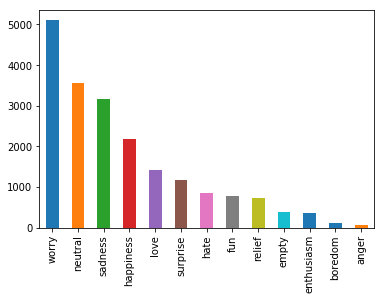

In [15]:
sentiment_freq = data['sentiment'].value_counts()
fig, ax = plt.subplots()

sentiment_freq.plot(ax=ax, kind='bar')

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2)

In [17]:
words_vocabulary = set([item for sublist in data_train['content'] for item in sublist])

Word2Vec + klasyfikator

In [18]:
X_train = data_train['content']
y_train = data_train['sentiment']
X_test = data_test['content']
y_test = data_test['sentiment']

In [19]:
model = gensim.models.Word2Vec(
    X_train,
    size=100,
    window=10,
    min_count=1,
    workers=10,
    negative = 5)
model.train(X_train, total_examples=len(X_train), epochs=10)

(1081950, 1790030)

In [20]:
model_name = 'word2vec'
model.save(model_name+'.model')
#model = gensim.models.Word2Vec.load(model_name+'.model')

In [21]:
EMBEDDING_DIM = 100

def create_random_vec(size=EMBEDDING_DIM):
    return np.random.rand(size)*2-1

BOS = create_random_vec(EMBEDDING_DIM)
EOS = create_random_vec(EMBEDDING_DIM)
PAD = np.zeros(EMBEDDING_DIM)

word_vectors = model.wv

word_vectors['<PAD>'] = PAD
word_vectors['<BOS>'] = BOS
word_vectors['<EOS>'] = EOS

def add_tags_to_sentence(sentence):
    new_sentence = []
    for word_id, word in enumerate(sentence):
        if word in word_vectors:
            new_sentence.append(word)
        else:
            sentence[word_id] = '<UNK>'
    return new_sentence


X_train = [add_tags_to_sentence(sentence) for sentence in X_train]
X_test = [add_tags_to_sentence(sentence) for sentence in X_test]

In [22]:
longest_sent = max([len(sentence) for sentence in X_train])

def vectorize_sentence(sentence):
    vectorized_sentence = np.zeros((longest_sent * EMBEDDING_DIM))
    for word_i, word in enumerate(sentence):
        if word == '<UNK>':
            vectorized_sentence[word_i*EMBEDDING_DIM:(word_i+1)*EMBEDDING_DIM] = create_random_vec()
        else:
            vectorized_sentence[word_i*EMBEDDING_DIM:(word_i+1)*EMBEDDING_DIM] = word_vectors[word]
    return vectorized_sentence

X_train = [vectorize_sentence(sent) for sent in X_train]
X_test = [vectorize_sentence(sent) for sent in X_test]

Random undersapling 

In [23]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [24]:
import pickle 

with open('xres', 'wb') as fp:
    pickle.dump(X_res, fp)

with open('yres', 'wb') as fp:
    pickle.dump(y_res, fp)
    
with open('xtest', 'wb') as fp:
    pickle.dump(X_test, fp)

with open('ytest', 'wb') as fp:
    pickle.dump(y_test, fp)

In [8]:
import pickle 

with open ('xres', 'rb') as fp:
    X_res = pickle.load(fp)
with open ('yres', 'rb') as fp:
    y_res = pickle.load(fp)
with open ('ytest', 'rb') as fp:
    X_test = pickle.load(fp)
with open ('xtest', 'rb') as fp:
    y_test = pickle.load(fp)


In [26]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import LinearSVC

 
param_grid = [
  {'C': [pow(2,-5), pow(2,-4), pow(2,-3), pow(2,-2), pow(2,-1), pow(2,0), pow(2,1), pow(2,2), pow(2,3),
            pow(2,4), pow(2,5)]}
]

estimator = LinearSVC(C=1)
clf = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1)
print(np.mean(cross_val_score(clf, X_res, y_res)))

/home/karolina/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/karolina/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.09776759188523894


/home/karolina/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
clf.fit(X_res, y_res)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                                16, 32]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [4]:
#pickle.dump(clf, open('svm', 'wb'))
clf = pickle.load(open('svm', 'rb'))

In [9]:
svm_score = clf.score(X_test, y_test)

In [10]:
svm_pred = clf.predict(X_test)

In [11]:
from sklearn.metrics import recall_score, precision_score, f1_score

f1_svm = f1_score(y_test, svm_pred, average='macro')
recall_svm = recall_score(y_test, svm_pred, average='macro')
precision_svm = precision_score(y_test, svm_pred, average='macro')

In [12]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed)

/home/karolina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [39]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
  {'n_neighbors':[1, 2, 3, 4, 5]},
]

estimator = KNeighborsClassifier(n_neighbors = 2)
neigh = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=kfold, n_jobs=3)
cross_val_score(neigh, X_res, y_res)

array([0.09090909, 0.1038961 , 0.09803922, 0.08496732, 0.11764706])

In [40]:
neigh.fit(X_res, y_res)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=2, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=3,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [13]:
#pickle.dump(neigh, open('knn', 'wb'))
neigh = pickle.load(open('knn', 'rb'))

In [14]:
knn_score = neigh.score(X_test, y_test)

In [15]:
knn_pred = neigh.predict(X_test)

f1_knn = f1_score(y_test, knn_pred, average='macro')
recall_knn = recall_score(y_test, knn_pred, average='macro')
precision_knn = precision_score(y_test, knn_pred, average='macro')

In [16]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [
  {'max_depth': [5, 10, 20, 40]}
]
estimator = DecisionTreeClassifier()
decisionTree = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1)
print(np.mean(cross_val_score(decisionTree, X_res, y_res)))

0.10301332654273829


In [17]:
print(np.mean(cross_val_score(decisionTree, X_res, y_res)))

0.09258976317799847


In [18]:
decisionTree.fit(X_res, y_res)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'max_depth': [5, 10, 20, 40]}],
             pre_di

In [19]:
pickle.dump(decisionTree, open('tree', 'wb'))
#decisionTree = pickle.load(open('tree', 'rb'))

In [20]:
tree_score = decisionTree.score(X_test, y_test)

In [21]:
tree_pred = decisionTree.predict(X_test)
f1_tree = f1_score(y_test, tree_pred, average='macro')
recall_tree = recall_score(y_test, tree_pred, average='macro')
precision_tree = precision_score(y_test, tree_pred, average='macro')

In [22]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
  {'max_depth': [5, 10, 20, None]}
]
estimator = RandomForestClassifier()
randomForest = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1)
print(np.mean(cross_val_score(decisionTree, X_res, y_res)))

0.09389695272048212


In [23]:
randomForest.fit(X_res, y_res)
forest_score = randomForest.score(X_test, y_test)

forest_pred = randomForest.predict(X_test)
f1_forest = f1_score(y_test, forest_pred, average='macro')
recall_forest = recall_score(y_test, forest_pred, average='macro')
precision_forest = precision_score(y_test, forest_pred, average='macro')

In [24]:
pickle.dump(randomForest, open('forest', 'wb'))
#randomForest = pickle.load(open('forest', 'rb'))

In [25]:
results = pd.DataFrame({"classifier": ['KNN', 'Decision Tree', 'SVM', 'Random forest'], 
                       "accuracy": [knn_score, tree_score, svm_score, forest_score],
                        "precision": [precision_knn, precision_tree, precision_svm, precision_forest],
                        "recall": [recall_knn, recall_tree, recall_svm, recall_forest],
                       "F1 score": [f1_knn,f1_tree, f1_svm, f1_forest]})


In [26]:
results

,classifier,accuracy,precision,recall,F1 score
0,KNN,0.034048,0.080953,0.064036,0.033951
1,Decision Tree,0.090542,0.092696,0.092331,0.071724
2,SVM,0.092308,0.091756,0.095151,0.077372
3,Random forest,0.095586,0.096494,0.097313,0.078956


Zależność między wartością parametru C w Linear SVM a otrzymaną wartością accuracy przy walidacji krzyżowej

Text(0,0.5,'Accuracy [%]')

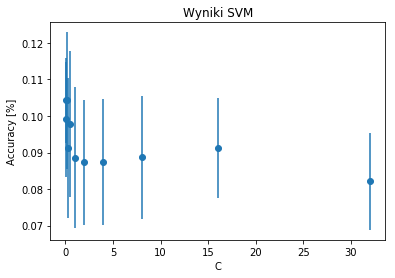

In [27]:
mean_score = clf.cv_results_['mean_test_score']
C_values = [pow(2,-5), pow(2,-4), pow(2,-3), pow(2,-2), pow(2,-1), pow(2,0), pow(2,1), pow(2,2), pow(2,3),
            pow(2,4), pow(2,5)]


plt.errorbar(C_values, mean_score, clf.cv_results_['std_test_score'], fmt='o')
plt.title("Wyniki SVM")
plt.xlabel("C")
plt.ylabel("Accuracy [%]")


Przykład działania modelu

In [30]:
data_test = pd.DataFrame(list(zip(X_test, y_test)), columns = ['content', 'sentiment'])

In [31]:
def check_results(test_id):
    example_id = data_test.index.values[test_id]
    example_text = data_copy.iloc[example_id]['content']
    example_label = data_copy.iloc[example_id]['sentiment']
    svm_label = svm_pred[test_id]
    knn_label = knn_pred[test_id]
    tree_label = tree_pred[test_id]
    forest_label = forest_pred[test_id]
    print(example_text)
    print(f'label: {example_label}')
    print(f'knn: {knn_label}, decision tree: {tree_label}, svm: {svm_label}, random forest: {forest_label}')
    print()

for i in range(5):
    check_results(i)

@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[
label: empty
knn: happiness, decision tree: happiness, svm: neutral, random forest: love

Layin n bed with a headache  ughhhh...waitin on your call...
label: sadness
knn: anger, decision tree: boredom, svm: worry, random forest: empty

Funeral ceremony...gloomy friday...
label: sadness
knn: happiness, decision tree: surprise, svm: neutral, random forest: happiness

wants to hang out with friends SOON!
label: enthusiasm
knn: boredom, decision tree: neutral, svm: love, random forest: sadness

@dannycastillo We want to trade with someone who has Houston tickets, but no one will.
label: neutral
knn: boredom, decision tree: empty, svm: enthusiasm, random forest: sadness

